In [1]:
# read all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#### a jupyter notebokk to demonstrate the use of the Oudin method for estimating the evaporation from a land surface

In [3]:
#load in the data
data = pd.read_excel('oudin.xlsx', index_col='datum', parse_dates=True)

In [4]:
#Where are we?
# -> in Graz
lat = 47

In [5]:
M = np.pi / 180 * lat
# M is the latitude of the location in radians

# calculate the extraterrestrial radiation

# first calculate the declination of the sun
# first calculate the day of the year
doy = data.index.dayofyear

# calculate the declination of the sun

dr = 1 + 0.033 * np.cos(2 * np.pi * doy / 365)
delta = 0.409 * np.sin(2 * np.pi * doy / 365 - 1.39)

omega_s = np.arccos(-np.tan(M) * np.tan(delta))

# dr is the inverse relative distance Earth-Sun????
# delta is the declination of the sun?????
# omega_s is the sunset hour angle?????

In [6]:
Re = 24 * 60 / np.pi * 0.082 * dr * (omega_s * np.sin(M) * np.sin(delta) + np.cos(M) * np.cos(delta) * np.sin(omega_s))
# Re is the extraterrestrial radiation in MJ/m2/day

In [7]:
def ETP_oudin(Re_mm_day, Temp_avg):
    """
    This function calculates the evapotranspiration according to the Oudin method
    Parameters
    ----------
    Re_mm_day : float
        Extraterrestrial radiation in mm/day
    Temp_avg : float
        Average temperature in degrees Celsius
    Returns
    -------
    ETP : float
        Evapotranspiration in mm/day
    """

    if Re_mm_day * (Temp_avg + 5) / 100 > 0:
        ETP = Re_mm_day * (Temp_avg + 5) / 100

    else:
        ETP = 0

    return ETP

In [8]:
Re_mm_day = Re / 2.45

ETP = np.zeros(len(data))

for i in np.arange(0, len(data)):
    ETP[i] = ETP_oudin(Re_mm_day[i], data['T (°C)'].values[i])


1. Show the relation ship between time of the year decilnation of the sun influencing extraterrestrial radiation  which than controlls the ETP

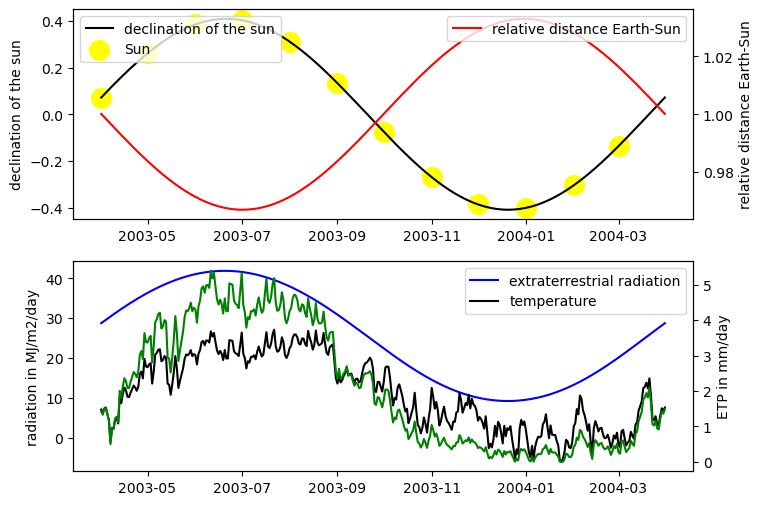

In [24]:
# create 3 subplots in one figure to show the different steps in the calculation of the ETP
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# plot the declination of the sun in an intuitive way so that students can understand what is happening
# plot sun symbols as scatter plot
ax1.plot(data.index, delta, color='black', label='declination of the sun')
# plot a yellow sun symbol for each first day of the month
ax1.scatter(data.index[data.index.day == 1], delta[data.index.day == 1], marker='o', color='yellow', label='Sun', s=200)

axtwin = ax1.twinx()
# plot relative distance Earth-Sun
axtwin.plot(data.index, dr, color='red', label='relative distance Earth-Sun')

# plot the extraterrestrial radiation
ax2.plot(data.index, Re, color='blue', label='extraterrestrial radiation')

# plot temperature
ax2.plot(data.index, data['T (°C)'], color='black', label='temperature')

ax3 = ax2.twinx()
# plot the ETP
ax3.plot(data.index, ETP, color='green', label='ETP')

# add labels and legend
ax1.set_ylabel('declination of the sun')
axtwin.set_ylabel('relative distance Earth-Sun')
ax2.set_ylabel('radiation in MJ/m2/day')
ax3.set_ylabel('ETP in mm/day')
ax1.legend(loc='upper left')
axtwin.legend(loc='upper right')
ax2.legend(loc='upper right')

In [10]:
# Now we go on to the ETR (real Evapotranspiration)

In [11]:
# first we need to add linear reduction functionn to calculate the ETR from the ETP ETR = f_r * ETP


Text(0, 0.5, 'Water stress coefficient K_s')

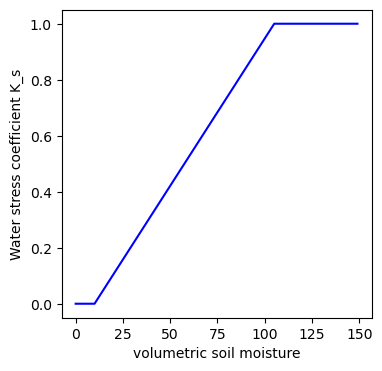

In [12]:
def linear_reduction_function(volumetric_soil_moisture, wilting_point, field_capacity, fraction_of_field_capacity=0.7):

    # calculate the "tipping point"
    theta_0 = field_capacity * fraction_of_field_capacity 

    #bypass for now
    theta_0 = 105

    if volumetric_soil_moisture >= theta_0:
        f_r = 1
    
    elif volumetric_soil_moisture <= wilting_point:
        f_r = 0

    elif volumetric_soil_moisture > wilting_point and volumetric_soil_moisture < theta_0:
        f_r = (volumetric_soil_moisture - wilting_point) / (theta_0 - wilting_point)

    return f_r

range = np.arange(0, 150, 1)

storage = np.zeros(len(range))

for i in range:
    storage[i] = linear_reduction_function(i, 10, 150, 0.7)


#plot the linear reduction function
plt.figure(figsize=(4, 4))
plt.plot(range, storage, color='blue', label='linear reduction function')
plt.xlabel('volumetric soil moisture')
plt.ylabel('Water stress coefficient K_s')

In [13]:
Precip = data['N (mm/d)']


In [14]:
# maximum soil moisture storage capacity = field capacity (150mm)??
fc = 150

delta_N_ETP = Precip - ETP

# this is also the starting value for the soil moisture storage
# soil moisture is fully saturated at the beginning of the simulation

In [15]:
def update_moisture_content(soilwater_content, PP, ETR, fc):

    # check if water holding capacity is exceeded
    if soilwater_content + PP - ETR > fc:
        updated_value = fc
        excess_water = soilwater_content + PP - ETR - fc

    else: 
        updated_value = soilwater_content + PP - ETR
        excess_water = 0

    return updated_value, excess_water

In [16]:
Re_mm_day = Re / 2.45

ETP = np.zeros(len(data))

for i in np.arange(0, len(data)):
    ETP[i] = ETP_oudin(Re_mm_day[i], data['T (°C)'].values[i])

In [17]:
# create simulation here 
# loop over all days

initial_soil_moisture = fc
initial_fraction_of_ETP = 1

# create empty arrays to store the results
soil_moisture = np.zeros(len(data))
ETR = np.zeros(len(data))

gw_flux = np.zeros(len(data))

# initialize the first value
soil_moisture[0] = initial_soil_moisture
ETR[0] = initial_fraction_of_ETP * ETP[0]

for i in np.arange(1,len(Precip)):
    delta_N_ETP = Precip[i] - ETP[i]

    factor = linear_reduction_function(soil_moisture[i-1], 10, fc, 0.7)
    ETR[i] = factor * ETP[i]

    # update the soil moisture content
    soil_moisture[i], excess_water = update_moisture_content(soil_moisture[i-1], Precip[i], ETR[i], fc)

    # calculate the groundwater flux
    gw_flux[i] = excess_water

In [18]:

#S_B_E
# if soilwater_cont[i-1] + PP[i] - ETR[i] > fc(150):
#     soilwater_cont[i] = fc(150)

# else: soilwater_cont[i-1] + PP[i] - ETR[i]

# language explanation: if the current soil water storage would be higher than the field capacity, then the soil water storage is set to the field capacity

#ETR/ETP how much of the ETP is actually used for evapotranspiration

# more N than ETP -> ETR = ETP (*1)
# less N than ETP -> ETR = N (*1)

#if delta_N_ETP < 0:

 #   if soilwater_cont[-1] > 0.7 * fc:
  #      result = 1
   # else:
    #    result = soilwater_cont[-1] / (K2 * K1)
    #else:
    #   result = 1

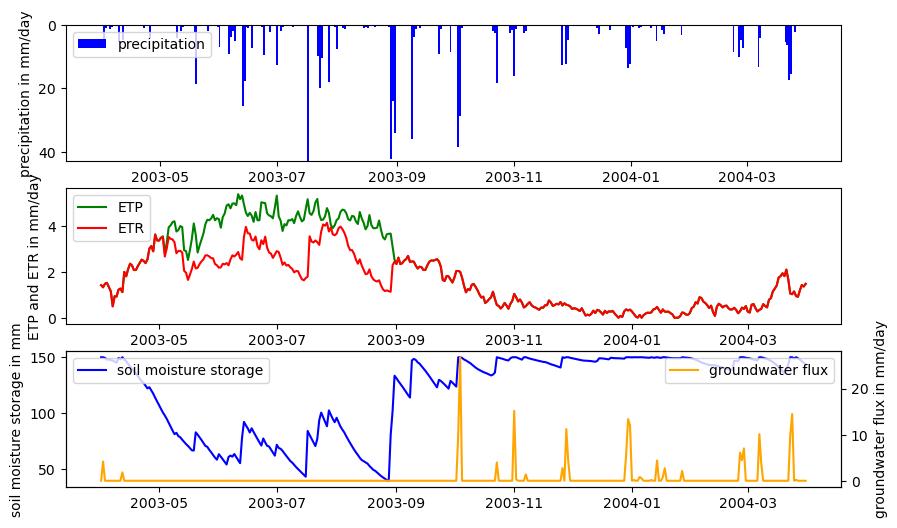

In [23]:
# create plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))

#plot precip as bars from starting form top of the plot
ax1.bar(data.index, Precip.values, color='blue', label='precipitation', width=1)
ax1.set_ylim(max(Precip), 0)  # This inverts the y-axis


# plot the ETP
ax2.plot(data.index, ETP, color='green', label='ETP')

# plot the ETR
ax2.plot(data.index, ETR, color='red', label='ETR')

# plot the soil moisture storage
ax3.plot(data.index, soil_moisture, color='blue', label='soil moisture storage')

ax4 = ax3.twinx()
# plot the groundwater flux
ax4.plot(data.index, gw_flux, color='orange', label='groundwater flux')

## add labels and legend
ax1.set_ylabel('precipitation in mm/day')
ax2.set_ylabel('ETP and ETR in mm/day')
ax3.set_ylabel('soil moisture storage in mm')
ax4.set_ylabel('groundwater flux in mm/day')
ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')



In [20]:
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, widgets

# Define the function to plot
def plot_func(frequency):
    x = np.linspace(0, 2*np.pi, 1000)
    y = np.sin(frequency * x)

    plt.plot(x, y)
    plt.ylim(-1.1, 1.1)
    plt.show()

# Create a slider and attach the plot function
interact(plot_func, frequency=widgets.FloatSlider(min=1.0, max=10.0, step=0.1, value=1.0));


interactive(children=(FloatSlider(value=1.0, description='frequency', max=10.0, min=1.0), Output()), _dom_clas…